In [6]:
import iris
import matplotlib.pyplot as plt
import iris.quickplot as qplt
import glob
import os
import numpy as np
import iris.coord_categorisation
import pandas as pd
import matplotlib
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec

In [7]:
yearsec=60.0*60.0-24.0

In [8]:
'''
Input should be:
Temperature in K
S in PSU (I think)
DIC and ALK in MOL? values about 2.0
'''

'''
NOTE - this is currently designed to work with a single time-interval (i.e. cube without a time dimension)
'''

import numpy as np
import numpy.ma as ma
import scipy.stats
import keyword
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=RuntimeWarning)

print'  ops= 0 ;  output is iteration count'
print'       1 ;            pCO2'
print'       2 ;            pH'
print'       3 ;            [H2CO3]'
print'       4 ;            [HCO3]'
print'       5 ;            [CO3]'
print'       6 ;            satn [co3] : calcite'
print'       7 ;            saturation state: calcite'
print'       8 ;            satn [CO3] : aragonite'
print'       9 ;            saturation state: aragonite'
print'       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010'
print'       11;            Alkalinity buffer factor calculated from Egleston et al. 2010'

print 'inputs: op_swtch,mdi,T,S,TCO2,TALK'

#Supply these as .data (arrays)
#salinity needs to be converted into psu *1000+35
#TCO2 and TALK must be in mol/kg /(1026.*1000.)
#the ones below here are not needed


def pressure_fun(a,b,c,d,e,T):
    del_vol = np.ones(T.shape, dtype='f')
    del_com = np.ones(T.shape, dtype='f') 
    pf = np.ones(T.shape, dtype='f')
    del_vol = a + b *T + c * np.power(T,2.0)
    del_com = 1.0e-3*( d + e*T )
    pf = np.exp( ( 0.5*del_com*Pr   - del_vol )*Pr / ( 83.131*TK ) )
    return pf

def carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW):
    aH = np.empty_like(T, dtype='f')
    aH.fill(1.0e-8)
    count = np.zeros_like(T)
    tol_swtch = np.zeros_like(T)
#MB -
#    AB = np.ones(T.shape)
#    AC = np.ones(T.shape)
#    AW = np.ones(T.shape)
    
    #MB+
    TBKB = TB * KB
    K2_K1x4 = 4.0 * K2 / K1
    K2_2 = 0.5 * K1
    #
    
    iter = 0
    test = 2.0
    while test > 0.5 and iter < mxiter:
        # Compute alkalinity guesses for Boron, Silicon, Phosphorus and Water
        #MB- AB = TB * KB / (aH + KB)
        #AB = TBKB / (aH + KB)
        AB = np.divide(TBKB,(aH + KB))
        #  ASi = TSi*KSi/( aH $
        #    + KSi )
        #  AP = TP*( 1.0/( 1.0 + KP2/aH $
        #    + KP2*KP3/(aH^2.0) ) + 2.0/( 1.0 $
        #    + aH/KP2 + KP3/aH ) $
        #    + 3.0/( 1.0 + aH/KP3 $
        #    + (aH^2.0)/(KP2*KP3) ) )
        AW = (KW / aH) - aH
        # using the guessed alkalinities and total alkalinity, calculate the
        # alkalinity due to carbon
        #  AC = TALK - ( AB + ASi $
        #    + AP + AW )
        AC = TALK - (AB + AW)
        # and recalculate aH with the new As
        #MB+
        TCO2_AC = TCO2 - AC
        #
        old_aH = np.copy(aH)
        #MB- aH = (0.5 * K1 / AC) * ((TCO2 - AC) + np.sqrt((TCO2 - AC) * (TCO2 - AC) + 4.0 * (AC * K2 / K1) * (2.0 * TCO2 - AC)))
        temp = TCO2_AC*TCO2_AC + (AC * K2_K1x4) * (2.0 * TCO2 - AC)
        aH = (K2_2 / AC) * (TCO2_AC + np.sqrt(temp))
        tol_swtch = abs((aH - old_aH) / old_aH) > tol
        count = count + tol_swtch
        test = np.sum(tol_swtch)
        iter += 1
        
    #aH[~msk] = 1.0
    #count[~msk] = 0
    return AC, AW, AB, aH, count


def carbchem_revelle(op_swtch,mdi,T_cube,S_cube,TCO2_cube,TALK_cube,Pr=0.0,TB=0.0,Ni=100.0,Tl=1.0e-5):
# This function calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines

#salinity needs to be converted into psu
#TCO2 and TALK must be in mol/kg
#the ones below here are not needed

# This procedure calculates the inorganic carbon chemistry balance
# according to the method of Peng et al 1987
# The parameters are set in the first few lines
#
#  ops= 0 ;  output is iteration count
#       1 ;            pCO2
#       2 ;            pH
#       3 ;            [H2CO3]
#       4 ;            [HCO3]
#       5 ;            [CO3]
#       6 ;            satn [co3] : calcite
#       7 ;            saturation state: calcite
#       8 ;            satn [CO3] : aragonite
#       9 ;            saturation state: aragonite
#	10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
#	11;            Alkalinity buffer factor calculated from Egleston et al. 2010

    #make sure grids are same size
    #make sure rthey years are the same
    #extarct the data from the cubes
    
# from iris import *
# from iris.analysis import *
# import iris.analysis
# from numpy import *
# from matplotlib.pyplot import *
# from scipy.stats.mstats import *
# import iris.plot as iplt
# import seawater
# import numpy
# import iris.quickplot as quickplot
# import iris.analysis.stats as istats
# temp = iris.load_cube('/home/ph290/tmp/hadgem2es_potential_temperature_historical_regridded.nc').extract(Constraint(depth = 0))
# sal = iris.load_cube('/home/ph290/tmp/hadgem2es_salinity_historical_regridded.nc').extract(Constraint(depth = 0))
# carb = iris.load_cube('/home/ph290/tmp/hadgem2es_dissolved_inorganic_carbon_historical_regridded.nc').extract(Constraint(depth = 0))
# alk = iris.load_cube('/home/ph290/tmp/hadgem2es_total_alkalinity_historical_regridded.nc').extract(Constraint(depth = 0))
# import carbchem
# co2 = carbchem.carbchem(1,temp.data.fill_value,temp,sal,carb,alk)
# T_cube = temp
# S_cube = sal
# TCO2_cube = carb
# TALK_cube = alk  
# mdi = temp.data.fill_value
	
    t_lat = np.size(T_cube.coord('latitude').points)    
    s_lat = np.size(S_cube.coord('latitude').points)
    c_lat = np.size(TCO2_cube.coord('latitude').points)
    a_lat = np.size(TALK_cube.coord('latitude').points)
    lat_test = t_lat == s_lat == c_lat == a_lat

    t_lon = np.size(T_cube.coord('longitude').points) 
    s_lon = np.size(S_cube.coord('longitude').points)
    c_lon = np.size(TCO2_cube.coord('longitude').points)
    a_lon = np.size(TALK_cube.coord('longitude').points)
    lon_test = t_lon == s_lon == c_lon == a_lon

    if lat_test and lon_test:

        output_cube = T_cube.copy()
        T_cube = T_cube
        T = T_cube.data.copy()
        S = S_cube.data.copy()
        TCO2_cube = TCO2_cube/1026.0
        # 		TCO2 = np.roll(ma.swapaxes(TCO2_cube.data.copy(),0,1),180)
        TCO2=TCO2_cube.data.copy()
        #NOTE - this is only required here 'cos glodap and WOA are differently ordered - not necessary for other stuff
        TALK_cube = TALK_cube/1026.0
        # 		TALK = np.roll(ma.swapaxes(TALK_cube.data.copy(),0,1),180)
        TALK = TALK_cube.data.copy()

#         print np.mean(T)
#         print np.mean(S)
#         print np.mean(TCO2)
#         print np.mean(TALK)
#         print np.shape(T)
#         print np.shape(S)
#         print np.shape(TCO2)
#         print np.shape(TALK)
        msk1=ma.masked_greater_equal(T,mdi-1.0,copy=True)
        msk2=ma.masked_greater_equal(S,mdi-1.0,copy=True)
        msk3=ma.masked_greater_equal(TCO2,mdi-1.0,copy=True)
        msk4=ma.masked_greater_equal(TALK,mdi-1.0,copy=True)

        msk=msk1.mask | msk2.mask | msk3.mask | msk4.mask

        T[msk]=np.nan
        S[msk]=np.nan
        TALK[msk]=np.nan
        TCO2[msk]=np.nan
        # 		plt.contourf(T)
        # 		plt.show()
        # 		plt.contourf(TCO2)
        # 		plt.show()

        # T = np.array([13.74232016,25.0])
        # S = np.array([33.74096661,35.0])
        # TCO2 = np.array([0.0019863,2.0e-3])
        # TALK = np.array([0.00226763,2.2e-3])
        # msk = ma.masked_greater_equal(T,mdi-1.0,copy=True)

        #create land-sea mask used by sea_msk.mask
        salmin = 1.0
        S2=np.copy(S)
        S2[np.abs(S) < salmin]=salmin

        tol = Tl
        mxiter = Ni

        op_fld = np.empty(T.shape)
        op_fld.fill(np.NAN)

        #    TB = np.ones(T.shape)
        #    TB = 4.106e-4*S2/35.0
        TB = np.empty_like(T)
        TB = np.multiply(S2,4.106e-4/35.0, TB)
        # this boron is from Peng

        #convert to Kelvin
        TK=np.copy(T[:])
        TK += +273.15

        alpha_s = np.ones(T.shape)
        alpha_s = np.exp( ( -60.2409 + 9345.17/TK  + 23.3585*np.log(TK/100.0) )  + ( 0.023517 - 0.023656*(TK/100.0) + 0.0047036*np.power((TK/100.0),2.0) )*S )

        K1 = np.ones(T.shape)
        K1 = np.exp( ( -2307.1266/TK + 2.83655  - 1.5529413*np.log(TK) ) - ( 4.0484/TK + 0.20760841 )*np.sqrt(S) + 0.08468345*S - 0.00654208*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        a = np.array([-25.50,-15.82,-29.48,-25.60,-48.76,-46.0])
        b = np.array([0.1271,0.0219,0.2324,0.5304,0.5304])
        c = np.array([0.0,0.0,0.0026080,0.0036246,0.0,0.0])
        d = np.array([-3.08,1.13,(-2.84e-3)/(1.0e-3),-5.13,-11.76,-11.76])
        e = np.array([0.0877,0.1475,0.0,0.0794,0.3692,0.3692])

        if keyword.iskeyword(Pr):
            instance = 0
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K1 = K1*pf

        K2 = np.ones(T.shape)
        K2 = np.exp( ( -3351.6106/TK - 9.226508 - 0.2005743*np.log(TK) ) - ( 23.9722/TK + 0.106901773 )*np.power(S,0.5) + 0.1130822*S - 0.00846934*np.power(S,1.5) + np.log( 1.0 - 0.001005*S ) )

        if keyword.iskeyword(Pr):
            instance = 1
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            K2 = K2*pf

        KB = np.ones(T.shape)
        KB = np.exp( ( -8966.90 - 2890.53*np.power(S,0.5) - 77.942*S + 1.728*np.power(S,1.5)- 0.0996*np.power(S,2.0) )/TK + ( 148.0248 + 137.1942*np.power(S,0.5) + 1.62142*S ) - ( 24.4344 + 25.085*np.power(S,0.5) + 0.2474*S )*np.log(TK) + 0.053105*(np.power(S,0.5))*TK )

        if keyword.iskeyword(Pr):
            instance = 2
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KB = KB*pf

        KW = np.ones(T.shape)
        KW = np.exp( ( -13847.26/TK + 148.96502 - 23.6521*np.log(TK) ) + ( 118.67/TK - 5.977 + 1.0495*np.log(TK) )*np.power(S,0.5) - 0.01615*S )

        if keyword.iskeyword(Pr):
            instance = 3
            pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
            KW = KW*pf

        if ( op_swtch >= 6 or op_swtch <= 9 ):
            ca_conc = np.ones(T.shape)
            ca_conc = 0.01028*S2/35.0

        if ( op_swtch == 6 or op_swtch == 7 ):
            K_SP_C = np.ones(T.shape)
            K_SP_C = np.power(10.0,( ( -171.9065 - 0.077993*TK + 2839.319/TK + 71.595*np.log10(TK) ) + ( -0.77712 + 0.0028426*TK + 178.34/TK )*np.power(S,0.5) - 0.07711*S+ 0.0041249*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 4
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_C = K_SP_C*pf


        if ( op_swtch == 8 or op_swtch == 9 ):
            K_SP_A = np.ones(T.shape)
            K_SP_A = np.power(10,( ( -171.945 - 0.077993*TK + 2903.293/TK + 71.595*np.log10(TK) ) + ( -0.068393 + 0.0017276*TK + 88.135/TK )*np.power(S,0.5) - 0.10018*S + 0.0059415*np.power(S,1.5) ))
            if keyword.iskeyword(Pr):
                instance = 5
                pf = pressure_fun(a[instance],b[instance],c[instance],d[instance],e[instance],T)
                K_SP_A = K_SP_A*pf


        # Get first estimate for H+ concentration.

        AC, AW, AB, aH, count = carbiter(T, TCO2, TALK, TB, msk, tol, mxiter, K1, K2, KB, KW)

        # 		plt.contourf(aH)
        # 		plt.show()
        # 		plt.contourf(AC)
        # 		plt.show()
        # 		plt.contourf(AW)
        # 		plt.show()
        # 		plt.contourf(aH)
        # 		plt.show()

        # now we have aH we can calculate...
        denom = np.zeros(T.shape)
        H2CO3 = np.zeros(T.shape)
        HCO3 = np.zeros(T.shape)
        CO3 = np.zeros(T.shape)
        pH = np.zeros(T.shape)
        pCO2 = np.zeros(T.shape)
        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = np.zeros(T.shape)
        if ( op_swtch == 7 ):
            sat_stat_C = np.zeros(T.shape)
        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = np.zeros(T.shape)
        if ( op_swtch == 9 ):
            sat_stat_A = np.zeros(T.shape)

        denom = np.power(aH,2.0) + K1*aH + K1*K2
        H2CO3 = TCO2*np.power(aH,2.0)/denom
        HCO3 = TCO2*K1*aH/denom
        CO3 = TCO2*K1*K2/denom
        # 		plt.contourf(K1)
        # 		plt.show()
        # 		plt.contourf(aH) -no
        # 		plt.show()
        # 		plt.contourf(denom) -no
        # 		plt.show()

        pH = -np.log10(aH)
        pCO2 = H2CO3/alpha_s

        if ( op_swtch == 6 or op_swtch == 7 ):
            sat_CO3_C = K_SP_C/ca_conc
            if ( op_swtch == 7 ):
                sat_stat_C = CO3/sat_CO3_C

        if ( op_swtch == 8 or op_swtch == 9 ):
            sat_CO3_A = K_SP_A/ca_conc
            if ( op_swtch == 9 ):
                sat_stat_A = CO3/sat_CO3_A

        TALKc=+HCO3+2*(CO3)
        var1=HCO3
        DIC_buffer=HCO3
        ALK_buffer=HCO3

        var1=HCO3+4*(CO3)+((aH*AB)/(KB+aH))-AW

        DIC_buffer=TCO2-((TALKc*TALKc)/var1)

        ALK_buffer=((TALKc*TALKc)-TCO2*var1)/TALKc

        output_cube = output_cube*0.0+np.nan
        if ( op_swtch == 0 ):
            op_fld = np.zeros(T.shape)
            op_fld = count
        elif ( op_swtch == 1 ):
            print np.mean(pCO2)
            output_cube.data = pCO2*1.0e6
            output_cube.standard_name = 'surface_partial_pressure_of_carbon_dioxide_in_sea_water'
            output_cube.long_name = 'CO2 concentration'
            output_cube.units = 'uatm'
        elif ( op_swtch == 2 ):
            output_cube.data = pH
            output_cube.standard_name = 'sea_water_ph_reported_on_total_scale'
            output_cube.long_name = 'pH'
            output_cube.units = '1'
        elif ( op_swtch == 3 ):
            output_cube.data = H2CO3
        elif ( op_swtch == 4 ):
            output_cube.data = HCO3
        elif ( op_swtch == 5 ):
            output_cube.data = CO3
        elif ( op_swtch == 6 ):
            output_cube.data = sat_CO3_C
        elif ( op_swtch == 7 ):
            output_cube.data = sat_stat_C
        elif ( op_swtch == 8 ):
            output_cube.data = sat_CO3_A
        elif ( op_swtch == 9 ):
            output_cube.data = sat_stat_A
        elif ( op_swtch == 10 ):
            output_cube.data = TCO2/DIC_buffer
        elif ( op_swtch == 11 ):
            output_cube.data = ALK_buffer*1000.0

        return output_cube


'''
test-data
'''

# def main():
# mdi=-999.0
# sizing=(500,500)
# T = np.empty(sizing)
# S = np.empty(sizing)
# TCO2 = np.empty(sizing)
# TALK = np.empty(sizing)
# T.fill(10.0)
# S.fill(35.0)
# TCO2.fill(0.0020)
# TALK.fill(0.0022)
# T[0,0]=mdi
# S[2,3]=mdi
# S[0,0]=0.5
# TALK[2,3]=mdi
# TCO2[2,3]=mdi
    
#     print carbchem(1,mdi,T,S,TCO2,TALK)

# import cProfile
# if __name__ == '__main__':
#     x=cProfile.run('main()')

#main()


  ops= 0 ;  output is iteration count
       1 ;            pCO2
       2 ;            pH
       3 ;            [H2CO3]
       4 ;            [HCO3]
       5 ;            [CO3]
       6 ;            satn [co3] : calcite
       7 ;            saturation state: calcite
       8 ;            satn [CO3] : aragonite
       9 ;            saturation state: aragonite
       10;            Ravelle factor (DIC) calculated from Egleston et al. 2010
       11;            Alkalinity buffer factor calculated from Egleston et al. 2010
inputs: op_swtch,mdi,T,S,TCO2,TALK


'\ntest-data\n'

Observational data

/home/ph290/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


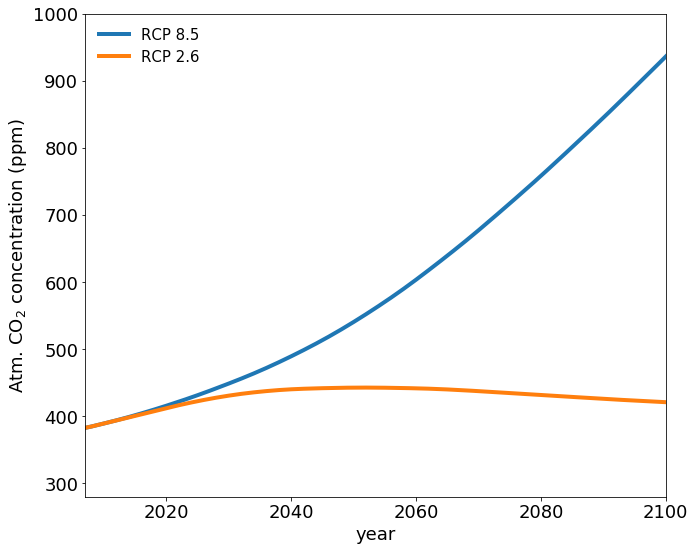

In [4]:
rcp85_data = '/data/NAS-ph290/ph290/misc_data/RCP85_MIDYR_CONC.DAT'
df_85 = pd.read_csv(rcp85_data,header=33,delim_whitespace=True)
rcp26_data = '/data/NAS-ph290/ph290/misc_data/RCP3PD_MIDYR_CONC.DAT'
df_26 = pd.read_csv(rcp26_data,header=33,delim_whitespace=True)


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

plt.figure(figsize=(10,8))
plt.plot(df_85.YEARS,df_85.CO2,lw=4,label='RCP 8.5')
plt.plot(df_26.YEARS,df_26.CO2,lw=4,label='RCP 2.6')



plt.xlim([2007,2100])
plt.ylim([280,1000])
plt.legend(loc=2,prop={'size': 15},frameon=False)
plt.xlabel('year')
plt.ylabel('Atm. CO$_2$ concentration (ppm)')

plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_atm_co2.png')

In [9]:
def model_names(directory):
	files = glob.glob(directory+'/*.nc')
	models_tmp = []
	for file in files:
		statinfo = os.stat(file)
		if statinfo.st_size >= 1:
			models_tmp.append(file.split('/')[-1].split('_')[0])
			models = np.unique(models_tmp)
	return models

def mask_where_zero(cube):
    cube.data = np.ma.masked_array(cube.data)
    cube.data.fill_value= 9.99e9
    cube.data[np.where(cube.data == 0.0)] = 9.99e9
    cube.data = np.ma.masked_where(cube.data == 9.99e9,cube.data)
    return cube

def extract_region(cube,lon_west,lon_east,lat_south,lat_north):
    cube_region_tmp = cube.intersection(longitude=(lon_west, lon_east))
    cube_region = cube_region_tmp.intersection(latitude=(lat_south, lat_north))
    return cube_region


def area_sum(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def area_avg(cube):
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return area_avged_cube

def area_sum2(cube,lon_west,lon_east,lat_south,lat_north):
    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.SUM, weights=grid_areas)
    return area_avged_cube

def area_avg2(cube,lon_west,lon_east,lat_south,lat_north):
    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
#     first_dim = cube.coord(dimensions=1).long_name #latitude
#     second_dim = cube.coord(dimensions=2).long_name #longitude
    try:
        cube.coord('latitude').guess_bounds()
    except:
        pass
    try:
        cube.coord('longitude').guess_bounds()
    except:
        pass
    grid_areas = iris.analysis.cartography.area_weights(cube)
    area_avged_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    return area_avged_cube

def avg_years(cube,start_yr,end_yr):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    loc = np.where((cube.coord('year').points >= start_yr) & (cube.coord('year').points <= end_yr))
    if len(loc[0]) > 0:
        return cube[loc].collapsed('time', iris.analysis.MEAN)
    else:
        cube=cube.collapsed('time', iris.analysis.MEAN)
        cube.data[:] = np.nan
        return cube

                   
def return_years(cube):
    try:
        iris.coord_categorisation.add_year(cube, 'time', name='year')
    except:
        pass
    return cube.coord('year').points




def populate_dict(data_dict,directory,models,variable,run,test_value):
    lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0
    for model in models:
        go_ahead = True
        print model
        exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
        if exists:
            cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
#             cube = cube.collapsed(['depth'],iris.analysis.MEAN)
            iris.coord_categorisation.add_year(cube, 'time', name='year')
            cube = cube.aggregated_by('year', iris.analysis.MEAN)
            test = cube.collapsed(['latitude','longitude','time'],iris.analysis.MEAN)
            if test_value:
                if test.data > 0.6e-9:
                    go_ahead=False
            if go_ahead:
                first_dim = cube.coord(dimensions=1).long_name #latitude
                if first_dim == 'latitude':
    #                 cube.coord(dimensions=1).rename('latitude')
    #                 cube.coord(dimensions=2).rename('longitude')
                    cube = extract_region(cube,lon_west,lon_east,lat_south,lat_north)
                    data_dict[run][variable][model] = {}
                    data_dict[run][variable][model]['timeseries'] = area_sum(cube)
                    data_dict[run][variable][model]['years'] = return_years(cube)
                    data_dict[run][variable][model]['first20'] = first_20_avg = avg_years(cube,2006,2026)
                    data_dict[run][variable][model]['last20'] = last_20_avg = avg_years(cube,2079,2099)
        else:
            print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict


def populate_dict_region(data_dict_region,directory,models,variables,runs,test_value,region_bounds):
    regions = list(region_bounds)
    #     lon_west,lon_east,lat_south,lat_north = W,E,S,N
    for i,region in enumerate(regions):
        W,E,S,N = region_bounds[region]['W'],region_bounds[region]['E'],region_bounds[region]['S'],region_bounds[region]['N']
        for run in runs:
            for variable in variables:
                for model in models:
                    exists = os.path.isfile(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                    if exists:
                        cube = iris.load_cube(directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc')
                        iris.coord_categorisation.add_year(cube, 'time', name='year')
                        cube = cube.aggregated_by('year', iris.analysis.MEAN)
                        cube = extract_region(cube,W,E,S,N)
                        data_dict_region[region][run][variable][model] = {}
                        data_dict_region[region][run][variable][model]['timeseries'] = area_sum(cube)
                        data_dict_region[region][run][variable][model]['years'] = return_years(cube)
                        data_dict_region[region][run][variable][model]['first20'] = avg_years(cube,2006,2026)
                        data_dict_region[region][run][variable][model]['last20'] = avg_years(cube,2079,2099)
                    else:
                        print directory+model+'_'+variable+'_'+run+'_r1i1p1_regridded.nc does not exist'
    return data_dict_region

In [6]:
directory = '/data/BatCaveNAS/ph290/noc_talk/regridded/'



In [7]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('CNRM-CM5')

data_dict = {}




In [8]:
variable = 'fgco2'
run = 'rcp85'
data_dict[run] = {}
data_dict[run][variable] = {}

In [9]:
data_dict = populate_dict(data_dict,directory,models,variable,run,True)

ACCESS1-0
/data/BatCaveNAS/ph290/noc_talk/regridded/ACCESS1-0_fgco2_rcp85_r1i1p1_regridded.nc does not exist
ACCESS1-3
/data/BatCaveNAS/ph290/noc_talk/regridded/ACCESS1-3_fgco2_rcp85_r1i1p1_regridded.nc does not exist
BNU-ESM


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1726: UnknownCellMethodWarning: NetCDF variable 'fgco2' contains unknown cell method 'where'
  warnings.warn(message=msg, category=UnknownCellMethodWarning)
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lat' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lon' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'time' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))


CCSM4
/data/BatCaveNAS/ph290/noc_talk/regridded/CCSM4_fgco2_rcp85_r1i1p1_regridded.nc does not exist
CESM1-BGC


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/analysis/cartography.py:377: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


CESM1-CAM5
/data/BatCaveNAS/ph290/noc_talk/regridded/CESM1-CAM5_fgco2_rcp85_r1i1p1_regridded.nc does not exist
CMCC-CESM
CMCC-CM
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CM_fgco2_rcp85_r1i1p1_regridded.nc does not exist
CMCC-CMS
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CMS_fgco2_rcp85_r1i1p1_regridded.nc does not exist
CSIRO-Mk3-6-0
/data/BatCaveNAS/ph290/noc_talk/regridded/CSIRO-Mk3-6-0_fgco2_rcp85_r1i1p1_regridded.nc does not exist
CanESM2
EC-EARTH
/data/BatCaveNAS/ph290/noc_talk/regridded/EC-EARTH_fgco2_rcp85_r1i1p1_regridded.nc does not exist
GFDL-CM3
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-CM3_fgco2_rcp85_r1i1p1_regridded.nc does not exist
GFDL-ESM2G
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-ESM2G_fgco2_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-H
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-H_fgco2_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-H-CC
GISS-E2-R
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-R_fgco2_rcp85_r1i1p1_regridded.nc d

/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2077: UserWarning: Failed to create 'time' dimension coordinate: The points array must be strictly monotonic.
Gracefully creating 'time' auxiliary coordinate instead.
  error=e_msg))


IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC-ESM
/data/BatCaveNAS/ph290/noc_talk/regridded/MIROC-ESM_fgco2_rcp85_r1i1p1_regridded.nc does not exist
MIROC-ESM-CHEM
MIROC5
/data/BatCaveNAS/ph290/noc_talk/regridded/MIROC5_fgco2_rcp85_r1i1p1_regridded.nc does not exist
MPI-ESM-LR
MPI-ESM-MR
MRI-CGCM3
/data/BatCaveNAS/ph290/noc_talk/regridded/MRI-CGCM3_fgco2_rcp85_r1i1p1_regridded.nc does not exist
NorESM1-M
/data/BatCaveNAS/ph290/noc_talk/regridded/NorESM1-M_fgco2_rcp85_r1i1p1_regridded.nc does not exist
NorESM1-ME
bcc-csm1-1
bcc-csm1-1-m
inmcm4


In [10]:
variable = 'fgco2'
run = 'rcp26'
data_dict[run] = {}
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,True)

ACCESS1-0
/data/BatCaveNAS/ph290/noc_talk/regridded/ACCESS1-0_fgco2_rcp26_r1i1p1_regridded.nc does not exist
ACCESS1-3
/data/BatCaveNAS/ph290/noc_talk/regridded/ACCESS1-3_fgco2_rcp26_r1i1p1_regridded.nc does not exist
BNU-ESM


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'fgco2'
  warnings.warn(message % (variable_name, nc_var_name))


CCSM4
/data/BatCaveNAS/ph290/noc_talk/regridded/CCSM4_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CESM1-BGC
/data/BatCaveNAS/ph290/noc_talk/regridded/CESM1-BGC_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CESM1-CAM5
/data/BatCaveNAS/ph290/noc_talk/regridded/CESM1-CAM5_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CMCC-CESM
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CESM_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CMCC-CM
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CM_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CMCC-CMS
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CMS_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CSIRO-Mk3-6-0
/data/BatCaveNAS/ph290/noc_talk/regridded/CSIRO-Mk3-6-0_fgco2_rcp26_r1i1p1_regridded.nc does not exist
CanESM2
EC-EARTH
/data/BatCaveNAS/ph290/noc_talk/regridded/EC-EARTH_fgco2_rcp26_r1i1p1_regridded.nc does not exist
GFDL-CM3
/data/BatCaveNAS/ph290/noc_talk/regridded/GFDL-CM3_fgco2_rcp26_r1i1p1_regridded.nc does not exist
GFDL-ESM2G
/data/Ba

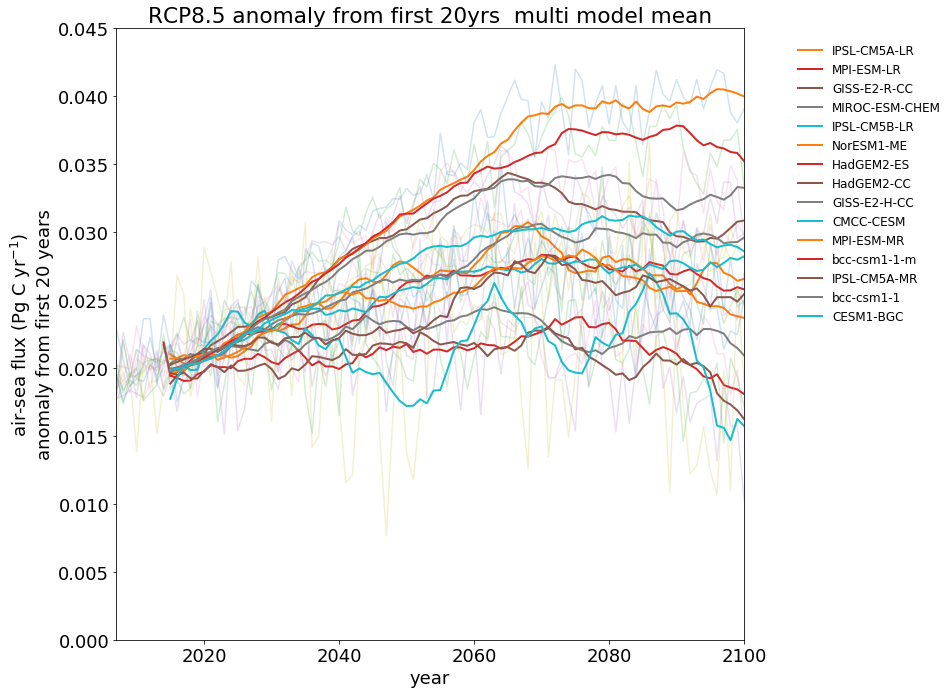

In [11]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('CNRM-CM5')

variable = 'fgco2'
run = 'rcp85'

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)


initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in data_dict[run][variable]])*365.0*yearsec)/1.0e12

plt.figure(figsize=(14,10))
for model in list(data_dict[run][variable]):
    df = pd.DataFrame({'tmp':(data_dict[run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
    plt.plot(data_dict[run][variable][model]['years'],initial_value+df.tmp-df.tmp[0:20].mean(),alpha=0.2,label='_nolegend_')
    plt.plot(data_dict[run][variable][model]['years'],initial_value+df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

plt.xlim([2007,2100])
plt.ylim([-0.00,0.045])
plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.title('RCP8.5 anomaly from first 20yrs  multi model mean')
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_rcp85_fgco2_ts.png')



['IPSL-CM5A-LR', 'MIROC-ESM', 'CanESM2', 'MIROC-ESM-CHEM', 'NorESM1-ME', 'HadGEM2-ES', 'MPI-ESM-MR', 'bcc-csm1-1-m', 'MPI-ESM-LR', 'bcc-csm1-1', 'IPSL-CM5A-MR']


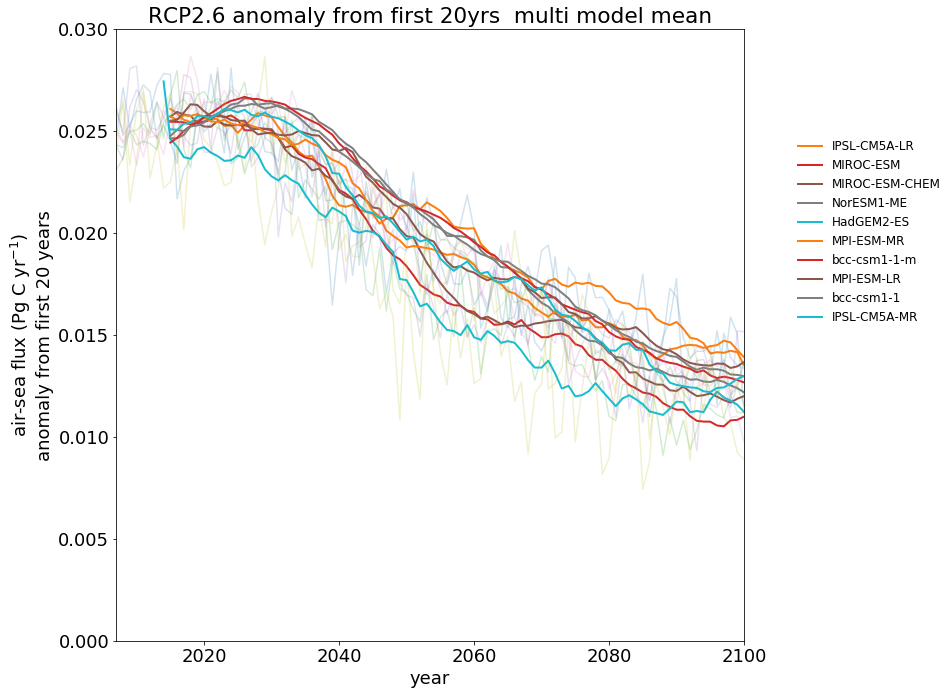

In [12]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('CNRM-CM5')

variable = 'fgco2'
run = 'rcp26'

print list(data_dict[run][variable])


font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in data_dict[run][variable]])*365.0*yearsec)/1.0e12


plt.figure(figsize=(14,10))
for model in list(data_dict[run][variable]):
    if model <> 'CanESM2':
        df = pd.DataFrame({'tmp':(data_dict[run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
        plt.plot(data_dict[run][variable][model]['years'],initial_value+df.tmp-df.tmp[0:20].mean(),alpha=0.2,label='_nolegend_')
        plt.plot(data_dict[run][variable][model]['years'],initial_value+df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

plt.xlim([2007,2100])
plt.ylim([0,0.03])
plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.title('RCP2.6 anomaly from first 20yrs  multi model mean')
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_rcp26_fgco2_ts.png')

In [13]:
def calculate_agreement(run_composites,agreement):
    # run_composites=run_composites[lag]
    composites_agreement = run_composites[0].copy()
    composites_agreement[:] = 0.0
    for i in range(np.shape(run_composites)[1]):
        for j in range(np.shape(run_composites)[2]):
            tmp1 = run_composites[:,i,j]
            a = np.float(len(np.where(tmp1 > 0.0)[0]))
            b = np.float(len(np.where(tmp1 < 0.0)[0]))
            ratio = np.max([a/len(tmp1),b/len(tmp1)])
            # if b > 0.0:
            #     ratio = (a / b)
            #     # print 'ratio ',ratio
            if ratio > agreement:
                composites_agreement[i,j] = np.NAN
            if run_composites[:,i,j].all() == 0.0:
            	composites_agreement[i,j] = np.NAN
    return composites_agreement

In [14]:
variable = 'fgco2'
run = 'rcp85'
models = list(data_dict[run][variable])
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data


diff = last_period-first_period

diff_mean = np.mean(diff,axis=0)

tmp_cube = data_dict[run][variable][model]['first20']
tmp_cube.data = diff_mean
agreement = 0.66
agreement_map = calculate_agreement(diff,agreement)

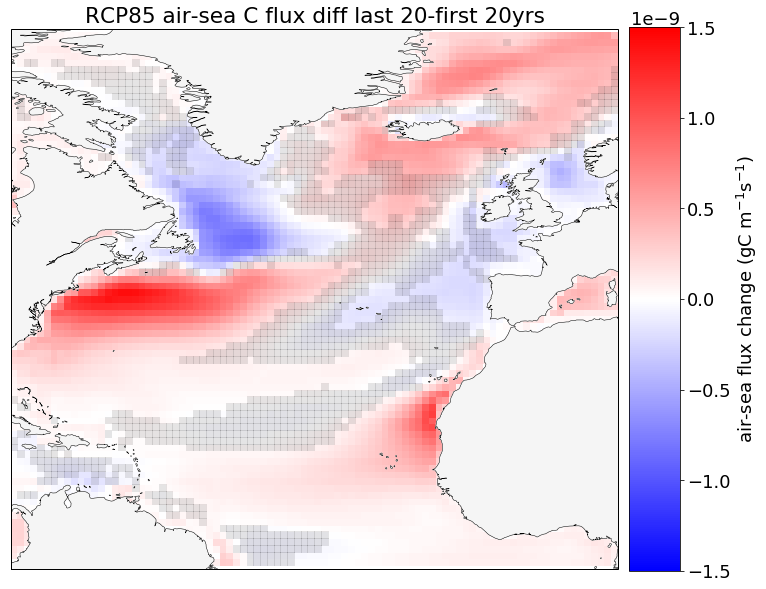

In [15]:
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])
coast_50m = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',facecolor='none')

my_projection = ccrs.PlateCarree()
my_extent = [-80.0,10,0.0,80.0]

plt.close('all')
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(10, 11)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)
ax2 = plt.subplot(gs[0:10,10:11])



ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = tmp_cube.coord('latitude').points
lons1 = tmp_cube.coord('longitude').points
data1 = tmp_cube.data


contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=-1.5E-9,vmax=1.5E-9,
			transform=ccrs.PlateCarree(),cmap='bwr')
contour_result2 = ax1.pcolormesh(lons1, lats1, agreement_map,
			transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1,alpha=0.1)

cbar = fig.colorbar(contour_result1, cax=ax2, orientation='vertical')
cbar.set_label('air-sea flux change (gC m$^{-1}$s$^{-1}$)')

ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)

ax1.set_title('RCP85 air-sea C flux diff last 20-first 20yrs')

plt.savefig('/home/ph290/Documents/figures/class_spatial_fgco2_diff.png')

Multi model mean change in update last 20 years - first 20 yeats 
greyed is where fewer than 66% of models agree on the sign of change

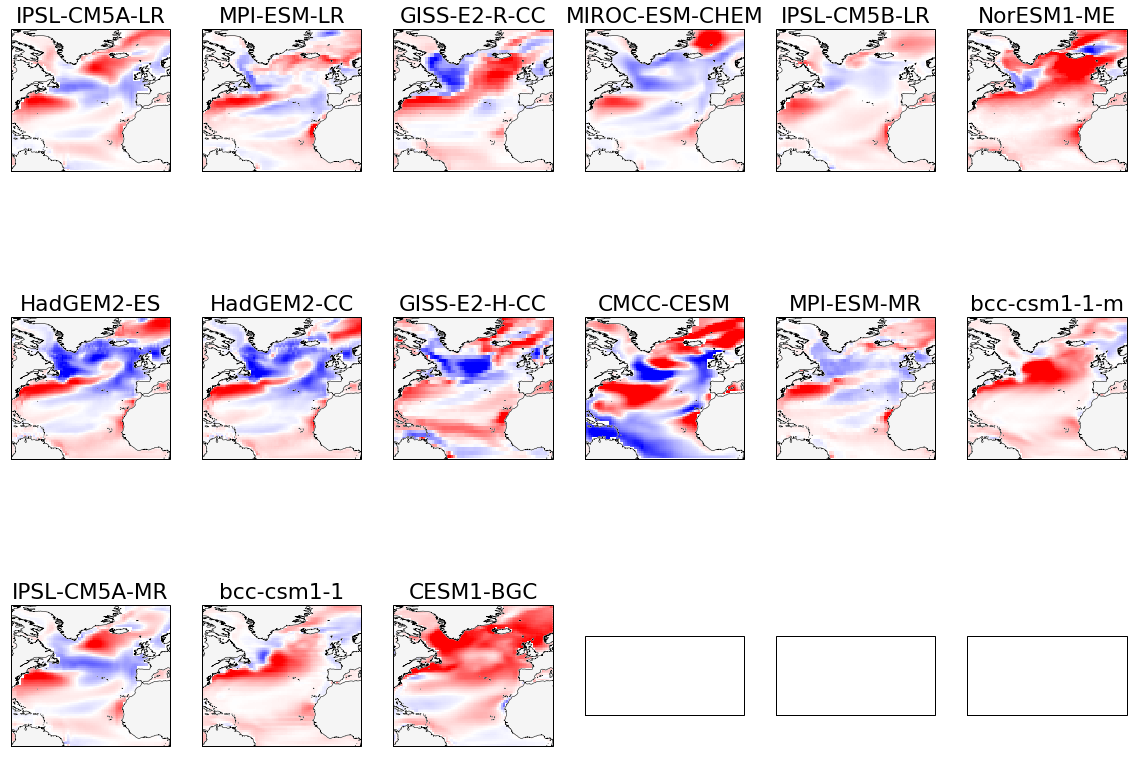

In [16]:
variable = 'fgco2'
run = 'rcp85'
models = list(data_dict[run][variable])

plt.close('all')
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(3, 6)


 

axs=[]
for i in range(3):
    for j in range(int(np.mean(len(models)/3.0))+1):
        axs.append(plt.subplot(gs[i:i+1,j:j+1],projection= my_projection))




for i,model in enumerate(models):
    tmp_cube = data_dict[run][variable][model]['last20'] - data_dict[run][variable][model]['first20'] 
    lats1 = tmp_cube.coord('latitude').points
    lons1 = tmp_cube.coord('longitude').points
    data1 = tmp_cube.data
    axs[i].set_extent(my_extent, crs=ccrs.PlateCarree())
    contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=-1.5E-9,vmax=1.5E-9,
        transform=ccrs.PlateCarree(),cmap='bwr')
    axs[i].add_feature(land_50m,facecolor='#F5F5F5')
    axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
    axs[i].set_title(model)




# cbar = fig.colorbar(contour_result1, cax=axs[-1])
# cbar.set_label('Revelle Factor')

plt.savefig('/home/ph290/Documents/figures/class_spatial_fgco2_by_model.png')

In [17]:
models = model_names(directory)
models = list(models)
models.remove('GFDL-ESM2M')
models.remove('GFDL-CM3')
models.remove('CNRM-CM5')
models.remove('MIROC-ESM-CHEM')
models.remove('GFDL-ESM2G')
models.remove('MIROC-ESM')
models.remove('inmcm4')

variable = 'talk'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,models,variable,run,False)

ACCESS1-0
/data/BatCaveNAS/ph290/noc_talk/regridded/ACCESS1-0_talk_rcp85_r1i1p1_regridded.nc does not exist
ACCESS1-3
/data/BatCaveNAS/ph290/noc_talk/regridded/ACCESS1-3_talk_rcp85_r1i1p1_regridded.nc does not exist
BNU-ESM


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'talk'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'volcello', referenced by netCDF variable u'talk'
  warnings.warn(message % (variable_name, nc_var_name))


CCSM4
/data/BatCaveNAS/ph290/noc_talk/regridded/CCSM4_talk_rcp85_r1i1p1_regridded.nc does not exist
CESM1-BGC
CESM1-CAM5
/data/BatCaveNAS/ph290/noc_talk/regridded/CESM1-CAM5_talk_rcp85_r1i1p1_regridded.nc does not exist
CMCC-CESM
CMCC-CM
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CM_talk_rcp85_r1i1p1_regridded.nc does not exist
CMCC-CMS
/data/BatCaveNAS/ph290/noc_talk/regridded/CMCC-CMS_talk_rcp85_r1i1p1_regridded.nc does not exist
CSIRO-Mk3-6-0
/data/BatCaveNAS/ph290/noc_talk/regridded/CSIRO-Mk3-6-0_talk_rcp85_r1i1p1_regridded.nc does not exist
CanESM2
EC-EARTH
/data/BatCaveNAS/ph290/noc_talk/regridded/EC-EARTH_talk_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-H
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-H_talk_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-H-CC
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-H-CC_talk_rcp85_r1i1p1_regridded.nc does not exist
GISS-E2-R
/data/BatCaveNAS/ph290/noc_talk/regridded/GISS-E2-R_talk_rcp85_r1i1p1_regridded.nc does not exist


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/coords.py:1210: UserWarning: Collapsing a non-contiguous coordinate. Metadata may not be fully descriptive for u'time'.
  warnings.warn(msg.format(self.name()))


IPSL-CM5A-LR
IPSL-CM5A-MR
IPSL-CM5B-LR
MIROC5
/data/BatCaveNAS/ph290/noc_talk/regridded/MIROC5_talk_rcp85_r1i1p1_regridded.nc does not exist
MPI-ESM-LR
MPI-ESM-MR
MRI-CGCM3
/data/BatCaveNAS/ph290/noc_talk/regridded/MRI-CGCM3_talk_rcp85_r1i1p1_regridded.nc does not exist
NorESM1-M
/data/BatCaveNAS/ph290/noc_talk/regridded/NorESM1-M_talk_rcp85_r1i1p1_regridded.nc does not exist
NorESM1-ME
bcc-csm1-1
/data/BatCaveNAS/ph290/noc_talk/regridded/bcc-csm1-1_talk_rcp85_r1i1p1_regridded.nc does not exist
bcc-csm1-1-m
/data/BatCaveNAS/ph290/noc_talk/regridded/bcc-csm1-1-m_talk_rcp85_r1i1p1_regridded.nc does not exist


In [18]:
variable = 'dissic'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,data_dict['rcp85']['talk'],variable,run,False)

IPSL-CM5A-LR


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'dissic'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'volcello', referenced by netCDF variable u'dissic'
  warnings.warn(message % (variable_name, nc_var_name))


MPI-ESM-LR
CanESM2
BNU-ESM
IPSL-CM5B-LR
NorESM1-ME
HadGEM2-ES
HadGEM2-CC
CMCC-CESM
MPI-ESM-MR
IPSL-CM5A-MR
CESM1-BGC


In [19]:
variable = 'tos'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,data_dict['rcp85']['talk'],variable,run,False)

IPSL-CM5A-LR


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'tos'
  warnings.warn(message % (variable_name, nc_var_name))


MPI-ESM-LR
CanESM2
BNU-ESM
/data/BatCaveNAS/ph290/noc_talk/regridded/BNU-ESM_tos_rcp85_r1i1p1_regridded.nc does not exist
IPSL-CM5B-LR
NorESM1-ME
HadGEM2-ES
HadGEM2-CC
CMCC-CESM
MPI-ESM-MR
IPSL-CM5A-MR
CESM1-BGC


In [20]:
variable = 'sos'
run = 'rcp85'
data_dict[run][variable] = {}
data_dict = populate_dict(data_dict,directory,data_dict['rcp85']['talk'],variable,run,False)

IPSL-CM5A-LR


/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/cf.py:798: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'sos'
  warnings.warn(message % (variable_name, nc_var_name))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'sos' invalid units u'psu'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))


MPI-ESM-LR
CanESM2
BNU-ESM
/data/BatCaveNAS/ph290/noc_talk/regridded/BNU-ESM_sos_rcp85_r1i1p1_regridded.nc does not exist
IPSL-CM5B-LR
NorESM1-ME
HadGEM2-ES
HadGEM2-CC
CMCC-CESM
MPI-ESM-MR
IPSL-CM5A-MR
CESM1-BGC


In [21]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_talk = data_dict[run][variable][model]['first20']
tmp_cube_talk.data = first_period_mean
tmp_cube_talk_2 = tmp_cube_talk.copy()
tmp_cube_talk_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'MPI-ESM-LR', 'CanESM2', 'BNU-ESM', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'IPSL-CM5A-MR', 'CESM1-BGC']


In [22]:
variable = 'dissic'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_dissic = data_dict[run][variable][model]['first20']
tmp_cube_dissic.data = first_period_mean
tmp_cube_dissic_2 = tmp_cube_dissic.copy()
tmp_cube_dissic_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'CESM1-BGC', 'CanESM2', 'BNU-ESM', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'MPI-ESM-LR', 'IPSL-CM5A-MR']


In [23]:
variable = 'tos'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_tos = data_dict[run][variable][model]['first20']
tmp_cube_tos.data = first_period_mean
tmp_cube_tos_2 = tmp_cube_tos.copy()
tmp_cube_tos_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'CESM1-BGC', 'CanESM2', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'MPI-ESM-LR', 'IPSL-CM5A-MR']


In [24]:
variable = 'sos'
run = 'rcp85'
models = list(data_dict[run][variable])
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_sos = data_dict[run][variable][model]['first20']
tmp_cube_sos.data = first_period_mean
tmp_cube_sos_2 = tmp_cube_sos.copy()
tmp_cube_sos_2.data = np.mean(last_period,axis=0)

['IPSL-CM5A-LR', 'CESM1-BGC', 'CanESM2', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'MPI-ESM-LR', 'IPSL-CM5A-MR']


In [25]:
tmp_cube_talk = mask_where_zero(tmp_cube_talk)
tmp_cube_dissic = mask_where_zero(tmp_cube_dissic)
tmp_cube_tos = mask_where_zero(tmp_cube_tos)
tmp_cube_sos = mask_where_zero(tmp_cube_sos)

# revelle_factor = carbchem_revelle(10,9.99e9,(tmp_cube_talk *0.0)+15.0,(tmp_cube_talk *0.0)+35.0,tmp_cube_dissic,tmp_cube_talk)
revelle_factor = carbchem_revelle(10,9.99e9,tmp_cube_tos-273.15,tmp_cube_sos,tmp_cube_dissic,tmp_cube_talk)
revelle_factor_last = carbchem_revelle(10,9.99e9,tmp_cube_tos_2-273.15,tmp_cube_sos_2,tmp_cube_dissic_2,tmp_cube_talk_2)

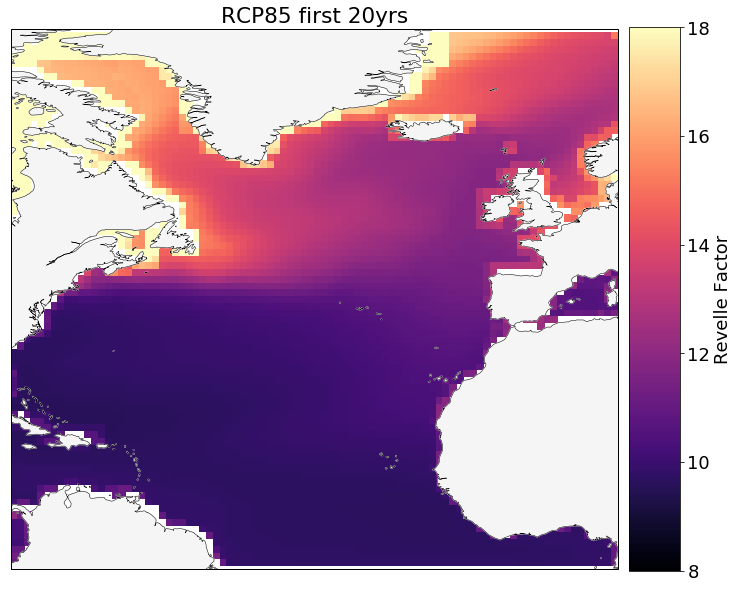

In [26]:


plt.close('all')
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(10, 11)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)
ax2 = plt.subplot(gs[0:10,10:11])



ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = revelle_factor.coord('latitude').points
lons1 = revelle_factor.coord('longitude').points
data1 = revelle_factor.data


contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=8,vmax=18,
			transform=ccrs.PlateCarree(),cmap='magma')


cbar = fig.colorbar(contour_result1, cax=ax2, orientation='vertical')
cbar.set_label('Revelle Factor')

ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)

ax1.set_title('RCP85 first 20yrs')

plt.savefig('/home/ph290/Documents/figures/class_spatial_revelle_diff.png')

Revelle each model

In [27]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
print models

['IPSL-CM5A-LR', 'MPI-ESM-LR', 'CanESM2', 'BNU-ESM', 'IPSL-CM5B-LR', 'NorESM1-ME', 'HadGEM2-ES', 'HadGEM2-CC', 'CMCC-CESM', 'MPI-ESM-MR', 'IPSL-CM5A-MR', 'CESM1-BGC']


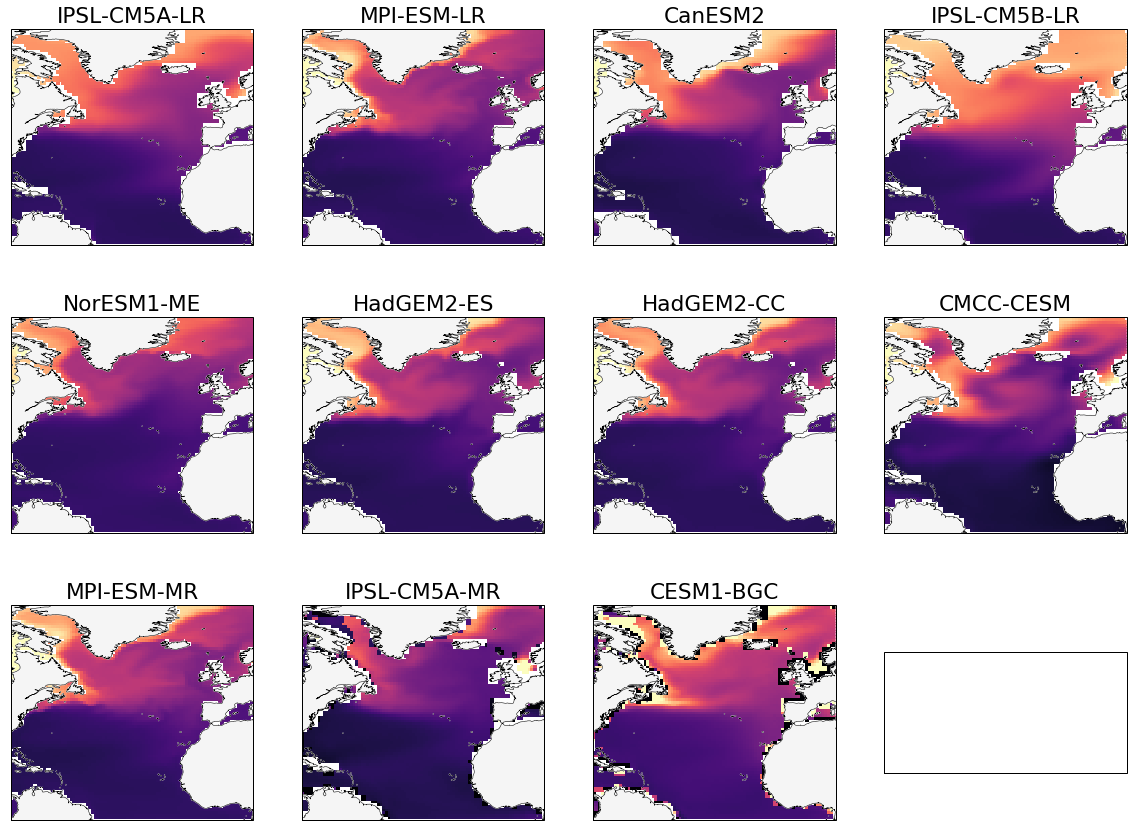

In [28]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
models.remove('BNU-ESM')

plt.close('all')
fig = plt.figure(figsize=(20,15))
gs = gridspec.GridSpec(3, 4)




 

axs=[]
for i in range(3):
    for j in range(int(np.mean(len(models)/3.0))+1):
        axs.append(plt.subplot(gs[i:i+1,j:j+1],projection= my_projection))




for i,model in enumerate(models):
    revelle_factor = carbchem_revelle(10,9.99e9,data_dict[run]['tos'][model]['first20']-273.15,data_dict[run]['sos'][model]['first20'],data_dict[run]['dissic'][model]['first20'],data_dict[run]['talk'][model]['first20'])
    lats1 = revelle_factor.coord('latitude').points
    lons1 = revelle_factor.coord('longitude').points
    data1 = revelle_factor.data
    axs[i].set_extent(my_extent, crs=ccrs.PlateCarree())
    contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=8,vmax=18,
        transform=ccrs.PlateCarree(),cmap='magma')
    axs[i].add_feature(land_50m,facecolor='#F5F5F5')
    axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
    axs[i].set_title(model)




# cbar = fig.colorbar(contour_result1, cax=axs[-1])
# cbar.set_label('Revelle Factor')

plt.savefig('/home/ph290/Documents/figures/class_spatial_revelle_by_model.png')


Subtropical relationship between revelle and change in CO2 flux

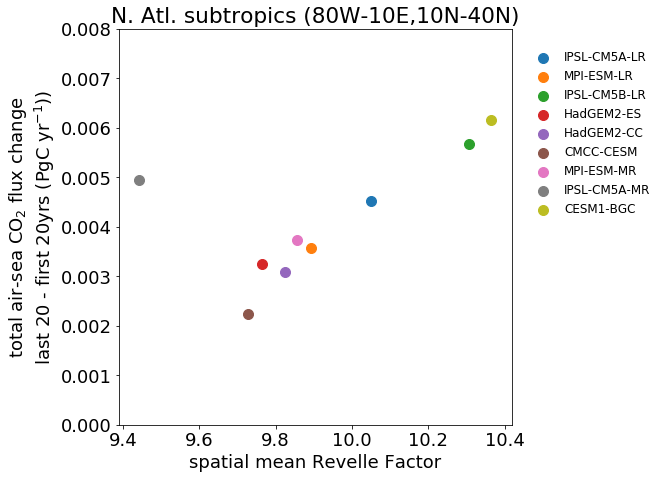

In [48]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
models.remove('CanESM2')
models.remove('BNU-ESM')

plt.close('all')
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0:1,0:1])



for i,model in enumerate(models):
    revelle_factor = carbchem_revelle(10,9.99e9,data_dict[run]['tos'][model]['first20']-273.15,data_dict[run]['sos'][model]['first20'],data_dict[run]['dissic'][model]['first20'],data_dict[run]['talk'][model]['first20'])
    rf_aa = area_avg2(revelle_factor,-80.0,10,10.0,40.0)
    fgco2_change = area_sum2(data_dict[run]['fgco2'][model]['last20'] - data_dict[run]['fgco2'][model]['first20'],-80.0,10,10.0,40.0)
    if model <> 'NorESM1-ME':
        ax1.scatter(rf_aa.data,(fgco2_change.data*365.0*yearsec)/1.0e12,s=100,label = model)



plt.ylim(0.0,0.008)
# cbar = fig.colorbar(contour_result1, cax=axs[-1])
# cbar.set_label('Revelle Factor')
plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
ax1.set_xlabel('spatial mean Revelle Factor')
ax1.set_ylabel('total air-sea CO$_2$ flux change\nlast 20 - first 20yrs (PgC yr$^{-1}$))')

plt.title('N. Atl. subtropics (80W-10E,10N-40N)')
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_scatter_revelle_v_fgco2.png')

Not Just N. Atl


In [30]:
import pickle

        
def populate_reg_bounds(region_bounds,regions,i,W,E,S,N):
    region_bounds[regions[i]]={}
    region_bounds[regions[i]]['W'],region_bounds[regions[i]]['E'],region_bounds[regions[i]]['S'],region_bounds[regions[i]]['N'] = W,E,S,N
    return region_bounds
    
try:
    with open('./region_data.pickle', 'r') as f:
       data_dict_region,variables,regions,region_bounds = pickle.load(f)
except:
    directory = '/data/BatCaveNAS/ph290/noc_talk/regridded/'

    variables = ['dissic','talk','tos','sos','fgco2']
#     regions = ['atl_n_subtropics','subtropics','atl_s_subtropics','pac_n_subtropicsE','pac_n_subtropicsW','pac_s_subtropicsE','pac_s_subtropicsW','global','atl_n_subpolar','pac_n_subpolarE','pac_n_subpolarW','S_ocean','arctic']
    regions = ['atl_n_subtropics','global','S_ocean','N_alt']
    region_bounds = {}

    region_bounds = populate_reg_bounds(region_bounds,regions,0,-80.0,10,10.0,40.0)
    region_bounds = populate_reg_bounds(region_bounds,regions,1,-180,180,-90,90.0)
    region_bounds = populate_reg_bounds(region_bounds,regions,2,-180,180,-90,-45)
    region_bounds = populate_reg_bounds(region_bounds,regions,3,-80,10,0,80)
    
#     region_bounds = populate_reg_bounds(region_bounds,regions,0,-80.0,10,10.0,40.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,1,-180.0,180,-40,40.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,2,-80.0,10,-40,-10.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,3,-180.0,-100,10,40.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,4,122.0,180.0,10,40.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,5,-180.0,-100,-40,-10.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,6,122.0,180.0,-40,-10.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,7,-180,180,-90,90.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,8,-80.0,10,45,65.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,9,-180.0,-100,45,56.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,10,122.0,180.0,45,56.0)
#     region_bounds = populate_reg_bounds(region_bounds,regions,11,-180,180,-90,-45)
#     region_bounds = populate_reg_bounds(region_bounds,regions,12,-180,180,70,90)    
    
    models = list(data_dict['rcp85']['talk'])
    runs = ['rcp85','rcp26']
    data_dict_region = {}
    for i,region in enumerate(list(region_bounds)):
        data_dict_region[region] = {}
        for run in runs:
            data_dict_region[region][run]={}
            for variable in variables:
                data_dict_region[region][run][variable]={}
                for model in models:
                    data_dict_region[region][run][variable][model]={}


    data_dict_region = populate_dict_region(data_dict_region,directory,models,variables,runs,False,region_bounds)
    with open('./region_data.pickle', 'w') as f:
        pickle.dump([data_dict_region,variables,regions,region_bounds], f)

        
        


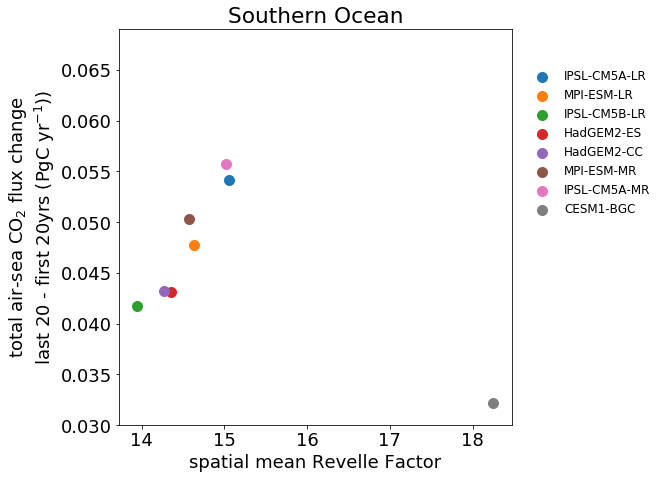

In [47]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
models.remove('CanESM2')
models.remove('BNU-ESM')
models.remove('CMCC-CESM')

plt.close('all')
fig = plt.figure(figsize=(10,7))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0:1,0:1])

#'atl_n_subtropics','subtropics','atl_s_subtropics','pac_n_subtropicsE','pac_n_subtropicsW','pac_s_subtropicsE','pac_s_subtropicsW','global','atl_n_subpolar','pac_n_subpolarE','pac_n_subpolarW','S_ocean','arctic'
regions = ['atl_n_subtropics','global','S_ocean','N_alt']
region = regions[2]

for i,model in enumerate(models):
    revelle_factor = carbchem_revelle(10,9.99e9,data_dict_region[region][run]['tos'][model]['first20']-273.15,data_dict_region[region][run]['sos'][model]['first20'],data_dict_region[region][run]['dissic'][model]['first20'],data_dict_region[region][run]['talk'][model]['first20'])
    rf_aa = area_avg(revelle_factor)
    fgco2_change = area_sum(data_dict_region[region][run]['fgco2'][model]['last20'] - data_dict_region[region][run]['fgco2'][model]['first20'])
    if model <> 'NorESM1-ME':
        ax1.scatter(rf_aa.data,(fgco2_change.data*365.0*yearsec)/1.0e12,s=100,label = model)

# plt.ylim(0.085,0.11)
# plt.xlim(11.0,11.7)2
# cbar = fig.colorbar(contour_result1, cax=axs[-1])
# cbar.set_label('Revelle Factor')
plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
ax1.set_xlabel('spatial mean Revelle Factor')
ax1.set_ylabel('total air-sea CO$_2$ flux change\nlast 20 - first 20yrs (PgC yr$^{-1}$))')

plt.title('Southern Ocean')
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_scatter_revelle_v_fgco2_s_ocean.png')

Global air-sea flux

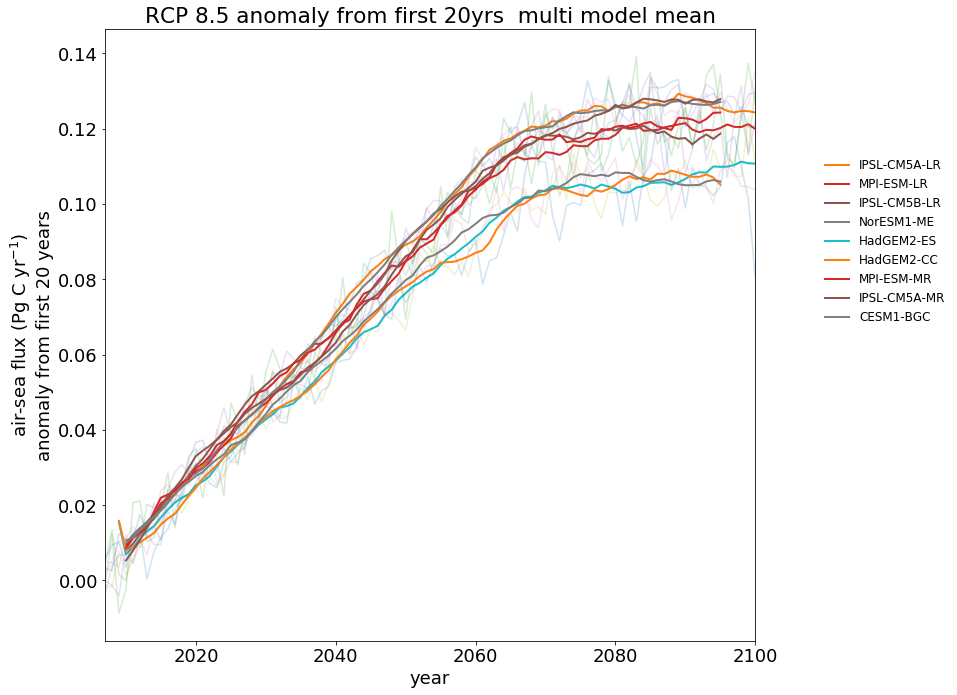

In [32]:
# models = model_names(directory)
# models = list(models)
# models.remove('GFDL-ESM2M')
# models.remove('CNRM-CM5')
models = list(data_dict['rcp85']['talk'])
models.remove('CanESM2')
models.remove('BNU-ESM')
models.remove('CMCC-CESM')
variable = 'fgco2'
run = 'rcp85'



font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

regions = ['atl_n_subtropics','global','S_ocean','N_alt']
region = regions[1]

initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in models])*365.0*yearsec)/1.0e12


plt.figure(figsize=(14,10))
for model in models: 
        df = pd.DataFrame({'tmp':(data_dict_region[region][run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
        plt.plot(data_dict_region[region][run][variable][model]['years'],initial_value+df.tmp-df.tmp[0:20].mean(),alpha=0.2,label='_nolegend_')
        plt.plot(data_dict_region[region][run][variable][model]['years']-5,initial_value+df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

plt.xlim([2007,2100])
# plt.ylim([0.01,0.04])
plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.title('RCP 8.5 anomaly from first 20yrs  multi model mean')
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/global_rcp85_fgco2_ts.png')

In [33]:
# models = model_names(directory)
# models = list(models)
# models.remove('GFDL-ESM2M')
# models.remove('CNRM-CM5')
models = list(data_dict[run][variable])
models.remove('CanESM2')
# models.remove('BNU-ESM')
# models.remove('CMCC-CESM')
# models.remove('IPSL-CM5B-LR')
variable = 'fgco2'
run = 'rcp26'



font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

regions = ['atl_n_subtropics','global','S_ocean','N_alt']
region = regions[1]

initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in models])*365.0*yearsec)/1.0e12


plt.figure(figsize=(14,10))
for model in models:
        try:
            df = pd.DataFrame({'tmp':(data_dict_region[region][run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
            plt.plot(data_dict_region[region][run][variable][model]['years'],initial_value+df.tmp-df.tmp[0:20].mean(),alpha=0.2,label='_nolegend_')
            plt.plot(data_dict_region[region][run][variable][model]['years']-5,initial_value+df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)
        except:
            print 'not OK'
        
plt.xlim([2007,2100])
# plt.ylim([0.01,0.04])
plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
plt.xlabel('year')
plt.ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
plt.title('RCP 2.6 anomaly from first 20yrs  multi model mean')
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/global_rcp26_fgco2_ts.png')

ValueError: list.remove(x): x not in list

In [ ]:

variable = 'fgco2'
run = 'rcp26'

models = list(data_dict_region[regions[0]][run][variable])
models.remove('CanESM2')
models.remove('BNU-ESM')
models.remove('CMCC-CESM')

if run == 'rcp26':
    models.remove('CESM1-BGC')
    models.remove('IPSL-CM5B-LR')
    models.remove('HadGEM2-CC')
#     models.remove('')

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

f = plt.figure(figsize=(12,10))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2,rowspan=2)
ax2 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
ax3 = plt.subplot2grid((3, 2), (2, 1), rowspan=1)

axs = [ax1,ax2,ax3]
# f, axarr = plt.subplots(2,2, figsize=(10,10))
regions = ['atl_n_subtropics','global','S_ocean','N_alt']
for i in [1,2,3]:
    region = regions[i]
    i-=1

    initial_value = (np.mean([area_sum(data_dict[run][variable][model]['first20']).data for model in models])*365.0*yearsec)/1.0e12

    for model in models: 
            df = pd.DataFrame({'tmp':(data_dict_region[region][run][variable][model]['timeseries'].data*365.0*yearsec)/1.0e12})
            axs[i].plot(data_dict_region[region][run][variable][model]['years'],initial_value+df.tmp-df.tmp[0:20].mean(),alpha=0.2,label='_nolegend_')
            axs[i].plot(data_dict_region[region][run][variable][model]['years']-5,initial_value+df.tmp.rolling(10).mean()-df.tmp[0:20].mean(),lw=2,label=model)

            axs[i].set_xlim([2007,2100])
#     plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)
    axs[1].set_xlabel('year')
    axs[2].set_xlabel('year')
    axs[0].set_ylabel('air-sea flux (Pg C yr$^{-1}$)\nanomaly from first 20 years')
    axs[1].set_title('Southern Ocean')
    axs[2].set_title('North Atlantic')
    axs[0].set_title('RCP 8.5 anomaly from first 20yrs  multi model mean\nGlobal')
#     axs[0].set_ylim([0.0175,0.0275])
plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/global_'+run+'_fgco2_ts.png')

subpolar relationship between revelle and change in CO2 flux

In [ ]:
variable = 'talk'
run = 'rcp85'
models = list(data_dict[run][variable])
models.remove('CanESM2')
models.remove('BNU-ESM')

plt.close('all')
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(1, 1)
ax1 = plt.subplot(gs[0:1,0:1])



for i,model in enumerate(models):
    revelle_factor = carbchem_revelle(10,9.99e9,data_dict[run]['tos'][model]['first20']-273.15,data_dict[run]['sos'][model]['first20'],data_dict[run]['dissic'][model]['first20'],data_dict[run]['talk'][model]['first20'])
    rf_aa = area_avg2(revelle_factor,-80.0,0,45.0,60.0)
    fgco2_change = area_sum2(data_dict[run]['fgco2'][model]['last20'] - data_dict[run]['fgco2'][model]['first20'],-80.0,0,45.0,60.0)
    if model <> 'NorESM1-ME':
        ax1.scatter(rf_aa.data,fgco2_change.data,label = model)
#     lats1 = revelle_factor.coord('latitude').points
#     lons1 = revelle_factor.coord('longitude').points
#     data1 = revelle_factor.data
#     axs[i].set_extent(my_extent, crs=ccrs.PlateCarree())
#     contour_result1 = axs[i].pcolormesh(lons1, lats1, data1,vmin=8,vmax=18,
#         transform=ccrs.PlateCarree(),cmap='magma')
#     axs[i].add_feature(land_50m,facecolor='#F5F5F5')
#     axs[i].add_feature(coast_50m,edgecolor='#000000',lw=0.5)
#     axs[i].set_title(model)




# cbar = fig.colorbar(contour_result1, cax=axs[-1])
# cbar.set_label('Revelle Factor')
plt.legend(loc=8, bbox_to_anchor=(1.2, 0.5),prop={'size': 12},frameon=False)

plt.savefig('/home/ph290/Documents/figures/class_scatter_revelle_v_fgco2_subpolar.png')

In [ ]:
print models
shape = np.shape(data_dict[run][variable][models[0]]['first20'])
first_period = np.zeros([len(data_dict[run][variable]),shape[0],shape[1]])
first_period[:] = np.nan
last_period=first_period.copy()
for i,model in enumerate(list(data_dict[run][variable])):
    first_period[i,:,:] = data_dict[run][variable][model]['first20'].data
    last_period[i,:,:] = data_dict[run][variable][model]['last20'].data



first_period_mean = np.mean(first_period,axis=0)

tmp_cube_sos = data_dict[run][variable][model]['first20']
tmp_cube_sos.data = first_period_mean
tmp_cube_sos_2 = tmp_cube_sos.copy()
tmp_cube_sos_2.data = np.mean(last_period,axis=0)

tmp_cube_talk = mask_where_zero(tmp_cube_talk)
tmp_cube_dissic = mask_where_zero(tmp_cube_dissic)
tmp_cube_tos = mask_where_zero(tmp_cube_tos)
tmp_cube_sos = mask_where_zero(tmp_cube_sos)

# revelle_factor = carbchem_revelle(10,9.99e9,(tmp_cube_talk *0.0)+15.0,(tmp_cube_talk *0.0)+35.0,tmp_cube_dissic,tmp_cube_talk)
revelle_factor = carbchem_revelle(10,9.99e9,tmp_cube_tos-273.15,tmp_cube_sos,tmp_cube_dissic,tmp_cube_talk)
revelle_factor_last = carbchem_revelle(10,9.99e9,tmp_cube_tos_2-273.15,tmp_cube_sos_2,tmp_cube_dissic_2,tmp_cube_talk_2)

plt.close('all')
fig = plt.figure(figsize=(12,10))
gs = gridspec.GridSpec(10, 11)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)
ax2 = plt.subplot(gs[0:10,10:11])



ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = revelle_factor.coord('latitude').points
lons1 = revelle_factor.coord('longitude').points
data1 = revelle_factor.data


contour_result1 = ax1.pcolormesh(lons1, lats1, data1,vmin=8,vmax=18,
			transform=ccrs.PlateCarree(),cmap='magma')


cbar = fig.colorbar(contour_result1, cax=ax2, orientation='vertical')
cbar.set_label('Revelle Factor')

ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)

ax1.set_title('RCP85 first 20yrs')

plt.savefig('/home/ph290/Documents/figures/class_spatial_revelle_diff.png')

In [ ]:
fig = plt.figure(figsize=(8,8))
gs = gridspec.GridSpec(10, 10)
ax1 = plt.subplot(gs[0:10,0:10],projection= my_projection)


ax1.set_extent(my_extent, crs=ccrs.PlateCarree())


lats1 = revelle_factor_last.coord('latitude').points
lons1 = revelle_factor_last.coord('longitude').points
data1 = revelle_factor_last.data


contour_result1 = ax1.contourf(lons1, lats1, data1,np.linspace(8,18,31),
			transform=ccrs.PlateCarree(),cmap='magma')


ax1.add_feature(land_50m,facecolor='#F5F5F5')
ax1.add_feature(coast_50m,edgecolor='#000000',lw=0.5)
plt.colorbar(contour_result1)

In [ ]:
dir2 = '/data/NAS-ph290/ph290/tmm/'
experiments = ['physics_only','fish_diss','weronika_experiment_one','low_carbonate_diss']
lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0

for experiment in experiments:
    cube = iris.load_cube(dir2+experiment+'/ALK_1300.nc')
    cube = area_avg2(cube,lon_west,lon_east,lat_south,lat_north)
    plt.plot(cube.data,cube.coord('Depth').points*-1.0,label=experiment)

plt.legend()

In [ ]:
glodap_dic_file ='/data/NAS-ph290/ph290/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TCO2.nc'
glodap_talk_file ='/data/NAS-ph290/ph290/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TAlk.nc'
glodap_dic = iris.load_cube(glodap_dic_file,'moles of dissolved inorganic carbon per unit mass in seawater')[0]/1026.0
glodap_talk = iris.load_cube(glodap_talk_file,'seawater alkalinity expressed as mole equivalent per unit mass')[0]/1026.0

lon_west,lon_east,lat_south,lat_north=-80.0,10,0.0,80.0
glodap_dic_n_atl = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_n_atl = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=-80.0,10,-45,0
glodap_dic_s_atl = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_s_atl = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=-180.0,180.0,-90.0,-45.0
glodap_dic_so = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_so = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=130,360-100,0,60
glodap_dic_np = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_np = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=130,360-100,-45,0
glodap_dic_sp = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_sp = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data

lon_west,lon_east,lat_south,lat_north=42,100,-45,20
glodap_dic_io = area_avg2(glodap_dic,lon_west,lon_east,lat_south,lat_north).data
glodap_talk_io = area_avg2(glodap_talk,lon_west,lon_east,lat_south,lat_north).data


In [ ]:
blue lines = revelle factor calculated at 5 degrees, colors and black lines at 20 degrees

In [45]:
# t=(data_dict[run]['tos'][model]['first20']*0.0)+15
s=(data_dict[run]['sos'][model]['first20']*0.0)+35.0
talk=data_dict[run]['dissic'][model]['first20']
dissic=data_dict[run]['talk'][model]['first20']
t.data[:]=20.0
s.data[:]=35.0
shape = np.shape(talk)
a=np.linspace(2.1,2.5,shape[0])
a2=np.tile(a,(shape[1],1))
a2 = np.flipud(np.rot90(a2))
d=np.linspace(1.8,2.2,shape[1])
d2=np.tile(d,(shape[0],1))
talk.data = a2
dissic.data = d2
# d=np.linspace(1.5,3.0,shape[1])
# aa, dd = np.meshgrid(a,d, sparse=True)
revelle_factor = carbchem_revelle(10,9.99e9,t,s,talk,dissic)

fig = plt.figure(figsize=(12,9))
cb1 = plt.contourf(d,a,revelle_factor.data,np.linspace(0,18,55),cmap='Reds')
cb1b = plt.contour(d,a,revelle_factor.data,10,linewidths=1,colors='k')
plt.clabel(cb1b, inline=1, fontsize=12)

t.data[:]=5.0
s.data[:]=35.0
revelle_factor = carbchem_revelle(10,9.99e9,t,s,talk,dissic)
cb2 = plt.contour(d,a,revelle_factor.data,10,linewidths=1,colors='b')
plt.clabel(cb2, inline=1, fontsize=12)


plt.xlabel('Dissolved Organic Carbon (mmol m$^{-3}$)')
plt.ylabel('Alkalinity (mmol equivalent m$^{-3}$)')


# plt.colorbar(cb1)
# plt.colorbar(cb2)



plt.scatter(glodap_dic_n_atl,glodap_talk_n_atl,label='N. Atl.',s=200)
plt.scatter(glodap_dic_s_atl,glodap_talk_s_atl,label='S. Atl.',s=200)
plt.scatter(glodap_dic_np,glodap_talk_np,label='N. Pacific',s=200)
plt.scatter(glodap_dic_sp,glodap_talk_sp,label='S. Pacific',s=200)
plt.scatter(glodap_dic_so,glodap_talk_so,label='S. Ocean',s=200)
plt.scatter(glodap_dic_io,glodap_talk_io,label='Indian',s=200)


plt.legend(loc=8, bbox_to_anchor=(1.1, 0.5),prop={'size': 15},frameon=False)



plt.tight_layout()
plt.savefig('/home/ph290/Documents/figures/class_revelle_explained.png')


NameError: name 't' is not defined

TMM stuff


In [3]:
glodap_dic_file ='/data/NAS-ph290/ph290/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TCO2.nc'
glodap_talk_file ='/data/NAS-ph290/ph290/observations/GLODAPv2_Mapped_Climatologies/GLODAPv2.2016b_MappedClimatologies/GLODAPv2.2016b.TAlk.nc'
glodap_dic = iris.load_cube(glodap_dic_file,'moles of dissolved inorganic carbon per unit mass in seawater')/1026.0
glodap_talk = iris.load_cube(glodap_talk_file,'seawater alkalinity expressed as mole equivalent per unit mass')/1026.0

glodap_depths = [   0.,   10.,   20.,   30.,   50.,   75.,  100.,  125.,  150.,        200.,  250.,  300.,  400.,  500.,  600.,  700.,  800.,  900.,       1000., 1100., 1200., 1300., 1400., 1500., 1750., 2000., 2500.,       3000., 3500., 4000., 4500., 5000., 5500.]

/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'TCO2' invalid units u'micro-mol kg-1'
  warnings.warn(msg.encode('ascii', errors='backslashreplace'))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lat' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:2030: UserWarning: Gracefully filling 'lon' dimension coordinate masked points
  warnings.warn(msg.format(str(cf_coord_var.cf_name)))
/home/ph290/anaconda2/lib/python2.7/site-packages/iris/fileformats/_pyke_rules/compiled_krb/fc_rules_cf_fc.py:1935: UserWarning: Ignoring netCDF variable u'Input_mean' invalid units u'micro-mol kg-1'
  warnings.warn(msg.encode('ascii', errors='backslashr

In [10]:
model_depths = [50, 120, 220, 360, 550, 790, 1080, 1420, 1810, 2250, 2740, 3280, 3870, 4510, 5200]

directory_deep = '/data/BatCaveNAS/ph290/tmm/paul_deep_dissolution/'
alk_files_deep = glob.glob(directory_deep+'ALK_*.nc')
dic_files_deep = glob.glob(directory_deep+'DIC_*.nc')

directory_shallow = '/data/BatCaveNAS/ph290/tmm/paul_shallow_dissolution/'
alk_files_shallow = glob.glob(directory_shallow+'ALK_*.nc')
dic_files_shallow = glob.glob(directory_shallow+'DIC_*.nc')

(5500, 0)

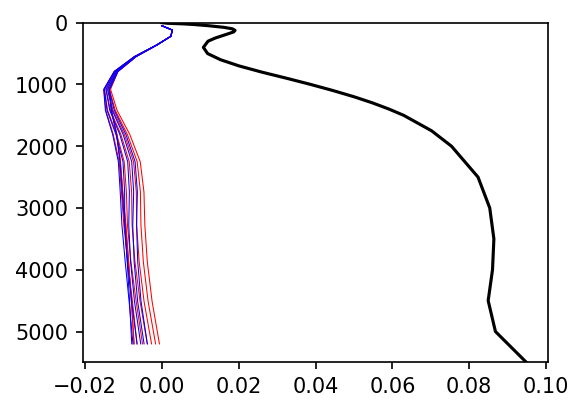

In [13]:
plt.figure(num=None, figsize=(4, 3), dpi=150, facecolor='none', edgecolor='none')

for i in range(len(alk_files_deep)):
    cube = iris.load_cube(alk_files_deep[i])
    plt.plot(area_avg(cube).data - area_avg(cube).data[0],model_depths,'r',lw=0.5)
    
for i in range(len(alk_files_shallow)):
    cube = iris.load_cube(alk_files_shallow[i])
    plt.plot(area_avg(cube).data - area_avg(cube).data[0],model_depths,'b',lw=0.5)


plt.plot(area_avg(glodap_talk).data - area_avg(glodap_talk).data[0],glodap_depths,'k')

# for i in range(len(alk_files_deep)):
#     cube = iris.load_cube(alk_files_deep[i])
#     plt.plot(area_avg(cube).data,model_depths,'r',lw=0.5)
    
# for i in range(len(alk_files_shallow)):
#     cube = iris.load_cube(alk_files_shallow[i])
#     plt.plot(area_avg(cube).data,model_depths,'b',lw=0.5)


# plt.plot(area_avg(glodap_talk).data,glodap_depths,'k')



plt.ylim([5500,0])

In [14]:
area_avg(glodap_talk)
len(glodap_depths)

33

(5500, 0)

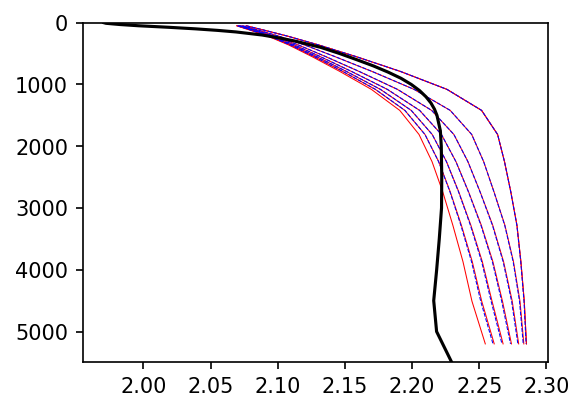

In [15]:

# for i in range(len(alk_files_deep)):
#     cube = iris.load_cube(dic_files_deep[i])
#     qplt.plot(area_avg(cube),'r')
    
# for i in range(len(alk_files_shallow)):
#     cube = iris.load_cube(_files_shallow[i])
#     qplt.plot(area_avg(cube),'b--')

    
plt.figure(num=None, figsize=(4, 3), dpi=150, facecolor='none', edgecolor='none')

# for i in range(len(dic_files_deep)):
#     cube = iris.load_cube(dic_files_deep[i])
#     plt.plot(area_avg(cube).data - area_avg(cube).data[0],model_depths,'r',lw=0.5)
    
# for i in range(len(dic_files_shallow)):
#     cube = iris.load_cube(dic_files_shallow[i])
#     plt.plot(area_avg(cube).data - area_avg(cube).data[0],model_depths,'b--',lw=0.5)


# plt.plot(area_avg(glodap_dic).data - area_avg(glodap_dic).data[0],glodap_depths,'k')
  
for i in range(len(dic_files_deep)):
    cube = iris.load_cube(dic_files_deep[i])
    plt.plot(area_avg(cube).data,model_depths,'r',lw=0.5)
    
for i in range(len(dic_files_shallow)):
    cube = iris.load_cube(dic_files_shallow[i])
    plt.plot(area_avg(cube).data,model_depths,'b--',lw=0.5)


plt.plot(area_avg(glodap_dic).data,glodap_depths,'k')
    
plt.ylim([5500,0])

In [ ]:
df=pd.read_csv('/data/BatCaveNAS/ph290/obs/SOCATv2019.tsv',delimiter='\t',header=5856)

In [ ]:
print list(df)


AttributeError: 'DataFrame' object has no attribute 'yr'

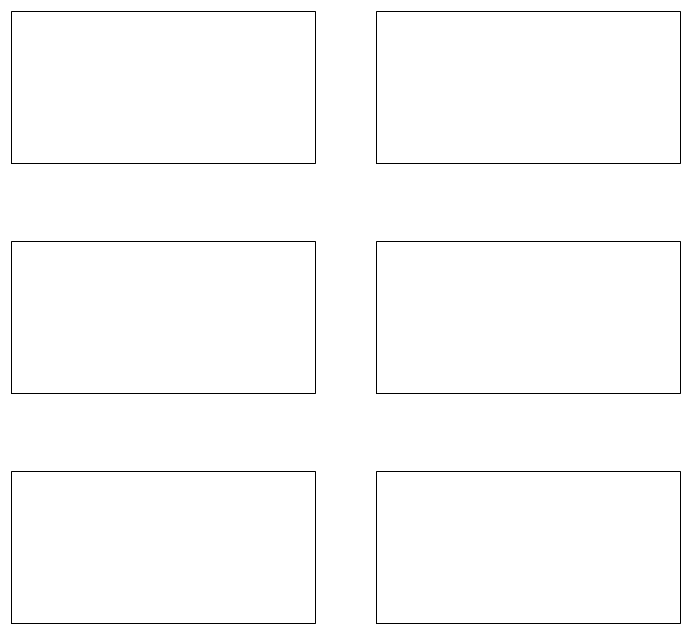

In [34]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='444444')

f = plt.figure(figsize=(12,12))
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1,projection=ccrs.PlateCarree())
ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1,projection=ccrs.PlateCarree())
ax3 = plt.subplot2grid((3, 2), (1, 0), rowspan=1,projection=ccrs.PlateCarree())
ax4 = plt.subplot2grid((3, 2), (1, 1), rowspan=1,projection=ccrs.PlateCarree())
ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1,projection=ccrs.PlateCarree())
ax6 = plt.subplot2grid((3, 2), (2, 1), rowspan=1,projection=ccrs.PlateCarree())



axs = [ax1,ax2,ax3,ax4,ax5,ax6]
setpoints = [1970,1980,1990,2000,2010,2020]

for i,setpoint in enumerate(setpoints):

    df_tmp = df[df.yr < setpoint]
    axs[i].coastlines()
    axs[i].scatter(df_tmp['longitude [dec.deg.E]'],df_tmp['latitude [dec.deg.N]'],s=0.1,alpha=0.01)
    axs[i].add_feature(land_50m)
    axs[i].set_global()
    axs[i].set_title('data up to '+str(setpoint))

plt.savefig('/home/ph290/Documents/figures/socat_data_availability.png')
plt.show()